<a href="https://colab.research.google.com/github/nitron-alpha-kplr/Generative-IA/blob/main/1.Autoencoders/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👖 Autoencoders on Fashion MNIST Dataset



> ### **!!! Attention :**

> #### **Avant de commencer le workshop, uploader les fichiers joignants au notebook dans le repository github "Generative IA"**






*   L'ensemble de données **Fashion-MNIST** est une collection d'images en niveaux de gris d'articles vestimentaires, chacune ayant une taille de 28 × 28 pixels.


*   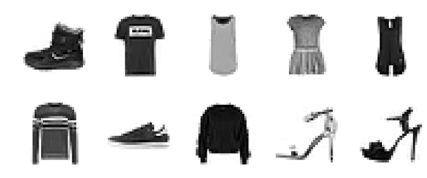


*   Dans ce notebook, nous allons parcourir les étapes nécessaires pour former votre propre autoencodeur sur l'ensemble de données Fashion MNIST.







*  Commencez par l'importation des différentes librairies que vous aurez besoin à savoir : Numpy, Matplotlib, et bien sur Tensorflow et Keras.


In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

from utils import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [ ]:
# Configuration des paramètres pour l'entraînement de votre Autoencoder.

# IMAGE_SIZE est défini à 32x32 pixels, ce qui sera la taille des images utilisées pour l'entraînement.
IMAGE_SIZE = 32

# CHANNELS est fixé à 1, indiquant que les images sont en niveaux de gris plutôt qu'en couleur.
CHANNELS = 1

# BATCH_SIZE est défini à 100, ce qui signifie que le modèle sera entraîné sur des lots de 100 images à la fois.
BATCH_SIZE = 100

# BUFFER_SIZE est réglé à 1000, ce qui spécifie la taille du tampon utilisée pour mélanger les données d'entraînement afin d'améliorer l'apprentissage du modèle.
BUFFER_SIZE = 1000

# VALIDATION_SPLIT est fixé à 0.2, ce qui signifie que 20% des données seront utilisées comme ensemble de validation pour évaluer la performance du modèle pendant l'entraînement.
VALIDATION_SPLIT = 0.2

# EMBEDDING_DIM est défini à 2, ce qui pourrait être utilisé dans le contexte de l'incorporation de mots dans un modèle de traitement du langage naturel (NLP), où cela représenterait la dimension de l'espace de plongement.
EMBEDDING_DIM = 2

# EPOCHS est réglé à 3, indiquant le nombre de fois que l'ensemble de données complet sera parcouru lors de l'entraînement du modèle.
EPOCHS = 3


## 1. Prepare the data <a name="prepare"></a>




*   L'ensemble de données est préinstallé avec TensorFlow, donc il peut être téléchargé comme suit :






In [ ]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Ce sont des images en niveaux de gris de 28 × 28 pixels (valeurs de pixels entre 0 et 255) par défaut, que nous devons prétraiter pour nous assurer que les valeurs de pixels sont mises à l'échelle entre 0 et 1.

Nous allons également ajouter un padding à chaque image pour la redimensionner en 32 × 32 pixels, ce qui facilitera la manipulation de la forme du tensor lorsqu'il traverse le réseau.

In [ ]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

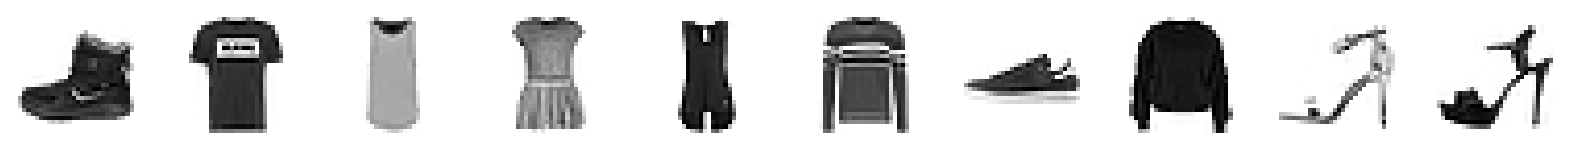

In [ ]:
# Affichez quelques articles vestimentaires de l'ensemble d'entraînement.
display(x_train)

## 2. Build the autoencoder <a name="build"></a>

*   Dans un autoencodeur, la tâche de l'encodeur est de prendre l'image d'entrée et de la mapper vers un vecteur d'embedding dans l'espace latent.

*   Pour le mettre en place, nous commençons par créer une couche d'entrée (Input layer) pour l'image et nous faisons passer celle-ci à travers trois couches Conv2D en séquence, capturant ainsi des caractéristiques de plus en plus abstraites.

*   Nous utilisons une stride de 2 pour réduire de moitié la taille de la sortie de chaque couche, tout en augmentant le nombre de canaux (channels).

*   La dernière couche de convolution est aplatie (flattened) et connectée à une couche Dense de taille 2, qui représente notre espace latent bidimensionnel.





In [ ]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable p

*   Le décodeur est l'image miroir de l'encodeur. Au lieu d'utiliser des couches de convolution, nous utilisons des couches de convolution transposée (Conv2DTranspose).

*   En Keras, la couche Conv2DTranspose nous permet d'effectuer des opérations de convolution transposée sur les tenseurs.

*   En empilant ces couches, nous pouvons progressivement augmenter la taille de chaque couche, en utilisant des strides de 2, jusqu'à revenir à la dimension d'image d'origine de 32 × 32.

In [ ]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       1846

*   Pour entraîner simultanément l'encodeur et le décodeur, nous devons définir un modèle qui représentera le flux d'une image à travers l'encodeur puis à travers le décodeur.
*   Heureusement, Keras facilite grandement cette tâche. Remarquez la manière dont nous spécifions que la sortie de l'autoencodeur est simplement la sortie de l'encodeur après avoir été passée à travers le décodeur.

In [ ]:
# Autoencoder
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  # decoder(encoder_output)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

## 3. Train the autoencoder <a name="train"></a>

In [ ]:
# Compilez l'autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
# Créez un modèle et sauvegardez un point de contrôle
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

*   Nous pouvons maintenant entraîner l'autoencodeur en utilisant les images d'entrée à la fois comme entrée et sortie.

In [ ]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3
600/600 [==============================] - ETA: 0s - loss: 0.2913

600/600 [==============================] - 321s 531ms/step - loss: 0.2913 - val_loss: 0.2613
Epoch 2/3
600/600 [==============================] - ETA: 0s - loss: 0.2572

600/600 [==============================] - 314s 523ms/step - loss: 0.2572 - val_loss: 0.2564
Epoch 3/3
600/600 [==============================] - ETA: 0s - loss: 0.2540

600/600 [==============================] - 310s 516ms/step - loss: 0.2540 - val_loss: 0.2542


In [ ]:
# Sauvegardez les modèles
autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

## 4. Reconstruct using the autoencoder <a name="reconstruct"></a>

* Nous pouvons tester la capacité de l'autoencodeur à reconstruire des images en faisant passer des images de l'ensemble de test à travers l'autoencodeur et en comparant la sortie avec les images originales.

In [ ]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 9s 58ms/step
Example real clothing items


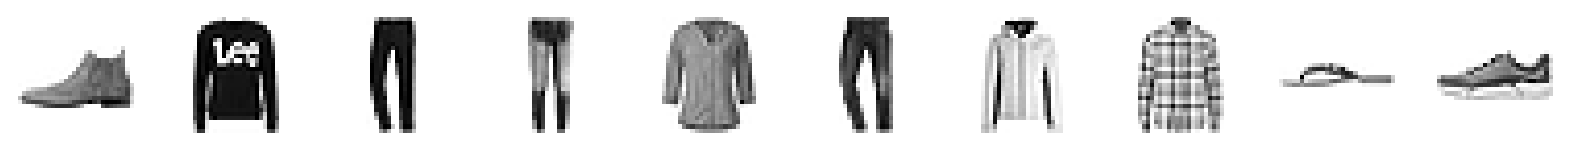

Reconstructions


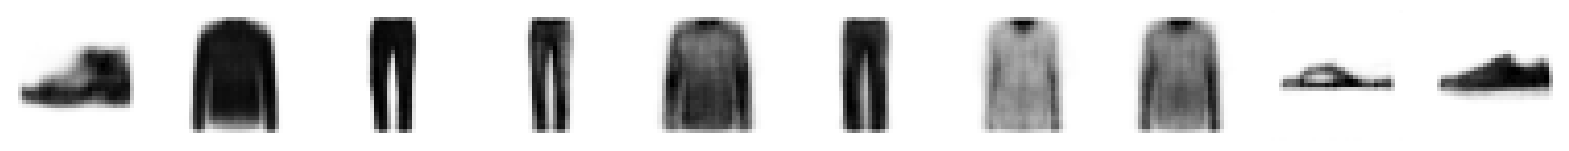

In [ ]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

## 5. Embed using the encoder <a name="encode"></a>

* Nous pouvons visualiser comment les images sont intégrées dans l'espace latent en faisant passer l'ensemble de test à travers l'encodeur et en traçant les plongements (embeddings) résultants.

In [ ]:
# Encode the example images
embeddings = encoder.predict(example_images)

157/157 [==============================] - 1s 8ms/step


In [ ]:
# Some examples of the embeddings
print(embeddings[:10])

[[ 2.0832899   0.89612603]
 [-1.8152001   6.433579  ]
 [-7.0780563  -0.9367418 ]
 [-3.925867   -0.8135788 ]
 [-0.5312612   3.5423658 ]
 [-5.0294247   0.31577417]
 [-0.9578585   1.8284955 ]
 [-0.92439854  2.7356312 ]
 [ 2.0234942  -1.2533584 ]
 [ 3.4158468  -0.34238434]]


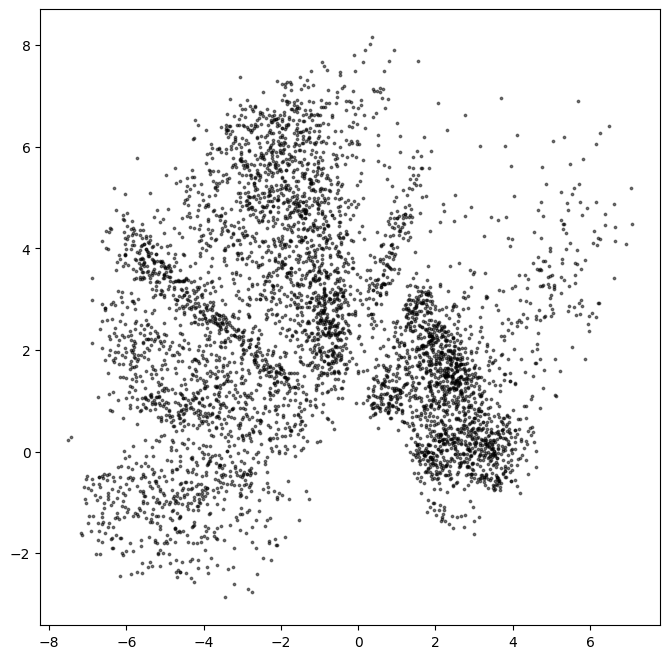

In [ ]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

* Chaque point noir représente une image qui a été intégrée dans l'espace latent.

* Pour mieux comprendre comment cet espace latent est structuré, nous pouvons utiliser les étiquettes fournies avec l'ensemble de données Fashion-MNIST, qui décrivent le type d'article dans chaque image.

* 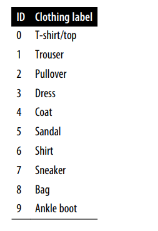

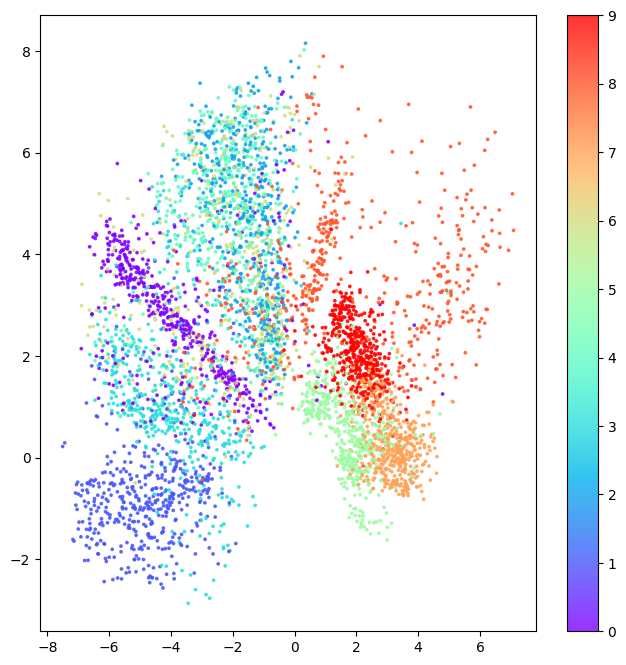

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## 6. Generate using the decoder <a name="decode"></a>

* Nous pouvons générer de nouvelles images en échantillonnant certains points dans l'espace latent et en utilisant le décodeur pour les convertir à nouveau dans l'espace de pixels.

In [ ]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [ ]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 156ms/step


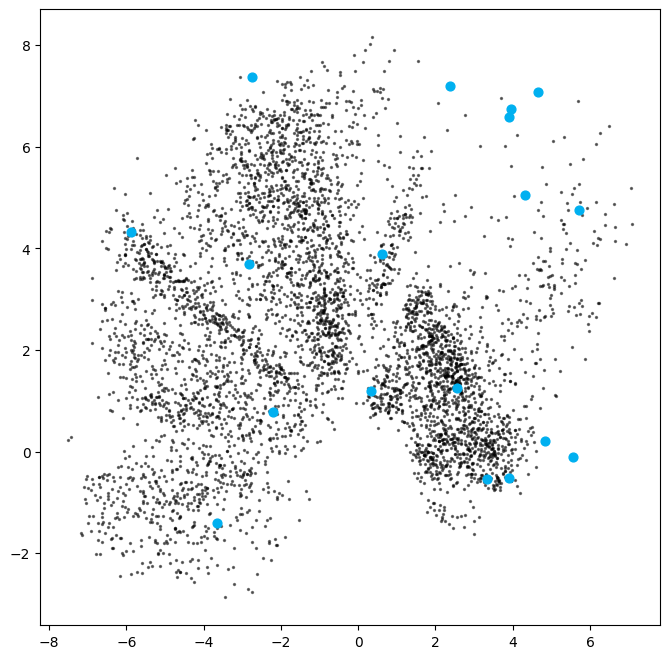

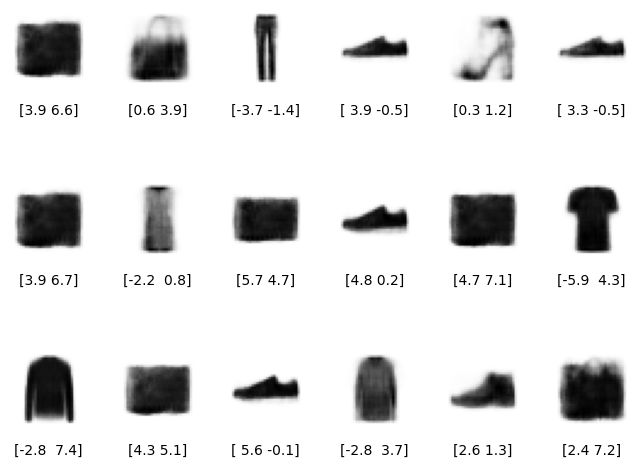

In [ ]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

Chaque point bleu est associé à l'une des images montrées en bas du diagramme, avec le vecteur d'intégration (embedding) affiché en dessous. Remarquez comment certaines des images générées sont plus réalistes que d'autres. Pourquoi cela ?

Pour répondre à cela, commençons par faire quelques observations sur la distribution globale des points dans l'espace latent:

* Certains articles vestimentaires sont représentés sur une toute petite zone, tandis que d'autres sont répartis sur une zone beaucoup plus grande.

* La distribution n'est pas symétrique par rapport au point (0, 0) et n'est pas bornée. Par exemple, il y a beaucoup plus de points avec des valeurs positives sur l'axe des y que de points négatifs, et certains points s'étendent même à des valeurs de l'axe des y > 8.

* Il existe de grands écarts entre les couleurs contenant peu de points.

Ces observations rendent en fait l'échantillonnage de l'espace latent assez complexe. Si nous superposons l'espace latent avec des images de points décodés sur une grille, nous pouvons commencer à comprendre pourquoi le décodeur ne génère pas toujours des images satisfaisantes.

8/8 [==============================] - 0s 40ms/step


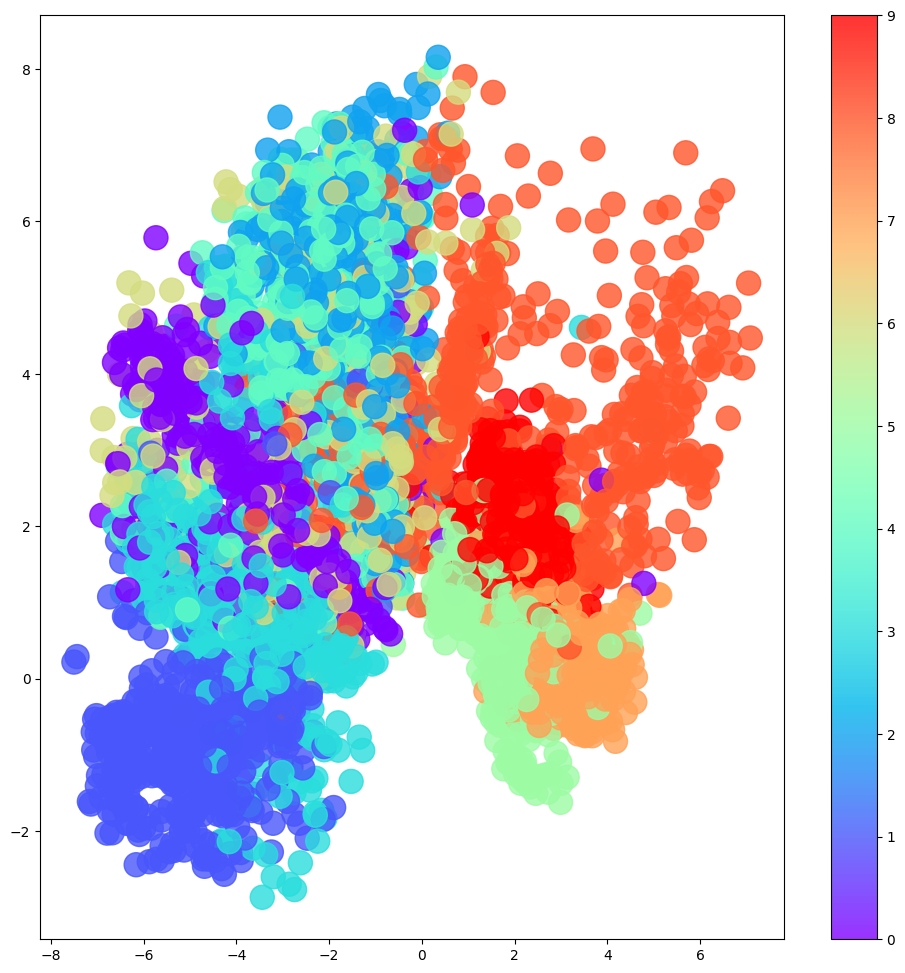

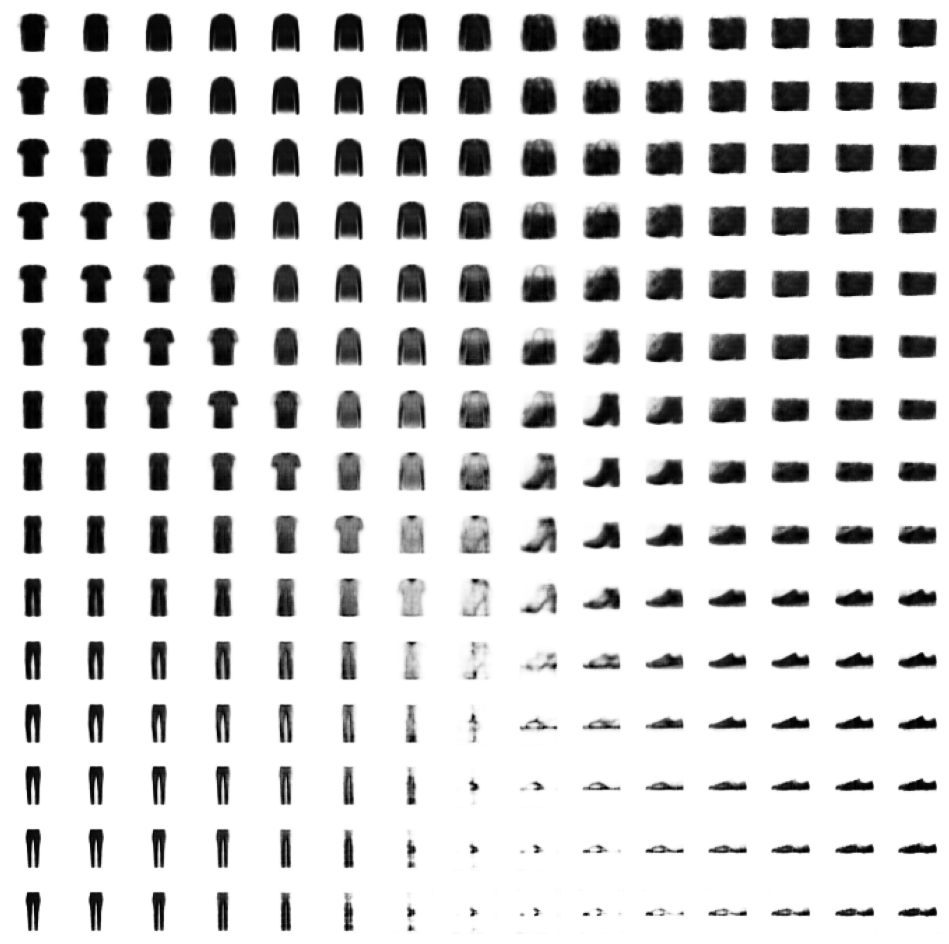

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")